In [15]:
import os
import sys
import asyncio
import logging

import numpy as np

import astropy.units as u

from lsst.ts import salobj


from lsst.ts.standardscripts.auxtel.attcs import ATTCS
from lsst.ts.standardscripts.auxtel.latiss import LATISS

In [115]:
import matplotlib.pyplot as plt

$HOME=/home/tribeiro
CONFIGDIR=/home/tribeiro/.config/matplotlib
matplotlib data path: /opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/matplotlib/mpl-data
loaded rc file /opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
matplotlib version 3.1.3
interactive is False
platform is linux
loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', 'imp', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'types', 'warnings', 'importlib.machinery', 'importlib.util', 'importl

In [2]:
os.environ["LSST_DDS_DOMAIN"] = 'lsatmcs'
os.environ["OSPL_URI"] = "file:///home/tribeiro/ospl.xml"

In [3]:
stream_handler = logging.StreamHandler(sys.stdout)

logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [4]:
attcs = ATTCS()

In [5]:
await attcs.start_task

Read historical data in 5.62 sec
Read historical data in 5.92 sec
Read historical data in 6.17 sec
Read historical data in 6.70 sec
Read historical data in 7.56 sec
Read historical data in 8.89 sec
Read historical data in 10.00 sec
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 29 messages


[None, None, None, None, None, None, None]

RemoteEvent(ATDome, 0, doorEncoderExtremes) falling behind; read 32 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 18 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 20 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 20 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 21 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 39 messages


In [8]:
await attcs.point_azel(az=0., el=15., wait_dome=False)

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -004.928 | delta Az= +000.001
[Telescope] delta Alt = -002.527 | delta Az= +000.001
[Telescope] delta Alt = -000.085 | delta Az= +000.000
[Telescope] delta Alt = +000.000 | delta Az= +000.000
Axes in position.
None


In [9]:
await attcs.stop_tracking()

Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.


In [145]:
class MeasureM1Pressure():
    
    def __init__(self, attcs):
        
        self.attcs = attcs
        self.elevation = np.array([])
        self.pressure = np.array([])
        self.load = np.array([])
        self.load_off = np.array([])
        self.max_load = np.array([])
        self.min_load = np.array([])
        
        self.min_allowed_load = 120.
        self.optimum_fraction = 1./3.
        self.tolerance = 0.01
        
    async def get_load(self, n=10):
        
        load_measures = np.zeros(n)
        for i in range(n):
            load = await self.attcs.atpneumatics.tel_loadCell.next(flush=True, timeout=2)
            load_measures[i] = load.cellLoad
            
        return np.mean(load_measures)
    
    async def get_pressure(self, n=10):
        
        pressure_measures = np.zeros(n)
        for i in range(n):
            topic = await self.attcs.atpneumatics.tel_m1AirPressure.next(flush=True, timeout=3)
            pressure_measures[i] = topic.pressure
            
        return np.mean(pressure_measures)*u.Pa

    async def get_elevation(self):
        encoders = await attcs.atmcs.tel_mount_AzEl_Encoders.aget()
        
        return encoders.elevationCalculatedAngle[-1]
    
    async def measure_optimum_load(self):
        
        elevation = await self.get_elevation()

        self.attcs.atpneumatics.evt_m1SetPressure.flush()

        await self.attcs.atpneumatics.cmd_m1SetPressure.set_start(pressure=0.)

        try:
            sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass
        
        current_load = await self.get_load()
        
        total_load = current_load * 3.
        
        optimum_load = total_load / 24.
        
        print(f"Optimum load @ el {elevation}: {optimum_load}")
        
        return elevation, optimum_load, current_load

    async def set_pressure(self, pressure):

        self.attcs.atpneumatics.evt_m1SetPressure.flush()
        
        self.attcs.atpneumatics.cmd_m1SetPressure.set(pressure=pressure.to(u.Pa).value)

        await attcs.atpneumatics.cmd_m1SetPressure.start()
        try:
            sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass
        
    async def measure_optimum_pressure(self, max_pressure):
        
        await self.set_pressure(0.*u.Pa)
        
        await asyncio.sleep(30.)

        el, opt_load, max_load = await self.measure_optimum_load()

        print(f"Elevation: {el}")
        print(f"Maximum load: {max_load}")
        print(f"Optimum load: {opt_load}")
        print(f"Maximum pressure: {max_pressure.to(u.Pa)}")

        await self.set_pressure(max_pressure)
        
        await asyncio.sleep(10.)

        measured_pressure = await self.get_pressure()

        min_load = await self.get_load()
        
        print(f"Load at maximum pressure: {min_load}")
        
        if min_load > opt_load:
            raise RuntimeError("Cannot compute optimum pressure. Minimum "
                               "load larger than optimum load.")
        
        niter = 0
        max_iter = 21
        success = True

        min_pressure = u.Pa*0.
        init_pressure = (min_pressure+max_pressure.to(u.Pa))/2.
        print("****")
        print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

        await self.set_pressure(init_pressure)

        load = await self.get_load()
        
        print(f"load: {load}")
        print(f"Optimum load: {opt_load}")
        delta = np.abs(load - opt_load)/opt_load
        print(f"{delta} | {self.tolerance}")
        print("****")
        
        while delta > self.tolerance:
            niter += 1
            print("****")
            print(f"Iter {niter}")

            if load - opt_load < 0.:
                max_pressure = init_pressure
            else:
                min_pressure = init_pressure
            init_pressure = (min_pressure+max_pressure)/2.
            print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

            await self.set_pressure(init_pressure)
            
            await asyncio.sleep(5.)

            load = await self.get_load()

            print(f"load: {load}")
            print(f"Optimum load: {opt_load}")
            delta = np.abs(load - opt_load)/opt_load
            print(f"diff: {delta} | tol: {self.tolerance}")
            print("****")

            if niter > max_iter:
                print("Failed")
                success = False
                break

        if success:
            print("Success!")
            optimum_pressure = init_pressure
            print(f"Optimum pressure: {optimum_pressure} @ el {elevation}")        
            self.elevation = np.append(self.elevation, elevation)
            self.pressure = np.append(self.pressure, optimum_pressure.to(u.Pa).value)    
            
        await self.set_pressure(0.*u.Pa)



In [146]:
mp = MeasureM1Pressure(attcs)

# Measuring optimum load with respect to elevation

In [113]:
load_elevation = np.linspace(20., 85., 20)
optimum_load = np.zeros(20)

In [114]:
for i in range(len(load_elevation)):
    await attcs.point_azel(az=0., el=load_elevation[i], wait_dome=False)
    res = await mp.measure_optimum_load()
    optimum_load[i] = res[1]

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -000.000 | delta Az= +000.001
Axes in position.
None
Optimum load @ el 20.000481067530927: 29.858819286346442
Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = +003.421 | delta Az= +000.001
[Telescope] delta Alt = +002.061 | delta Az= +000.001
[Telescope] delta Alt = +000.0

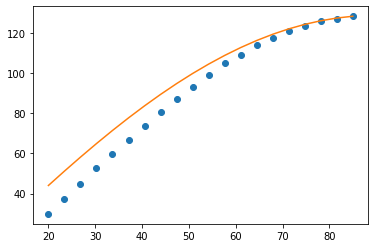

RemoteEvent(ATMCS, 0, target) falling behind; read 40 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 15 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 15 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 11 messages
RemoteTelemetry(ATMCS, 0, nasymth_m3_mountMotorEncoders) falling behind; read 15 messages
RemoteTelemetry(ATMCS, 0, mount_Nasmyth_Encoders) falling behind; read 15 messages
RemoteTelemetry(ATMCS, 0, mount_AzEl_Encoders) falling behind; read 14 messages
RemoteTelemetry(ATMCS, 0, measuredTorque) falling behind; read 15 messages
RemoteTelemetry(ATMCS, 0, measuredMotorVelocity) falling behind; read 15 messages
RemoteTelemetry(ATMCS, 0, azEl_mountMotorEncoders) falling behind; read 15 messages
RemoteEvent(ATMCS, 0, heartbeat) falling behind; read 17 messages


In [117]:
ref_load = optimum_load[-1]
ref_el = load_elevation[-1]

coef = ref_load/np.cos(np.radians(90.-ref_el))

plt.plot(load_elevation, optimum_load, 'o')
plt.plot(load_elevation, coef*np.cos(np.radians(90-load_elevation)))

In [118]:
np.save("alt_optimum_load.npy", np.array([load_elevation, optimum_load]))

In [122]:
optimum_load[-1],optimum_load[0]

(128.17911841163635, 29.858819286346442)

# Measure optimum pressure with respect to elevation

In [128]:
max_pressure = 40e3*u.Pa
elevation = 20.

In [147]:
await mp.measure_optimum_pressure(max_pressure)

Optimum load @ el 20.000004975416232: 32.00950609931946
Elevation: 20.000004975416232
Maximum load: 256.0760487945557
Optimum load: 32.00950609931946
Maximum pressure: 40000.0 Pa
Load at maximum pressure: 23.56057932128906
****
Init pressure: 20000.0 Pa (0.5)
load: 140.1064411010742
Optimum load: 32.00950609931946
3.3770260205312246 | 0.01
****
****
Iter 1
Init pressure: 30000.0 Pa (0.75)
load: 97.2464404724121
Optimum load: 32.00950609931946
diff: 2.0380487649723413 | tol: 0.01
****
****
Iter 2
Init pressure: 35000.0 Pa (0.875)
load: 51.391819079589844
Optimum load: 32.00950609931946
diff: 0.605517402240782 | tol: 0.01
****
****
Iter 3
Init pressure: 37500.0 Pa (0.9375)
load: 21.978425875854494
Optimum load: 32.00950609931946
diff: 0.3133781631100591 | tol: 0.01
****
****
Iter 4
Init pressure: 36250.0 Pa (0.9666666666666667)
load: 40.513580868530276
Optimum load: 32.00950609931946
diff: 0.2656734141046812 | tol: 0.01
****
****
Iter 5
Init pressure: 36875.0 Pa (0.9833333333333333)
load

In [150]:
await attcs.point_azel(az=0., el=load_elevation[1], wait_dome=False)

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = +003.421 | delta Az= +000.001
[Telescope] delta Alt = +002.025 | delta Az= +000.001
[Telescope] delta Alt = +000.056 | delta Az= +000.001
[Telescope] delta Alt = -000.000 | delta Az= +000.000
Axes in position.
None


In [154]:
coeff = 40e3*u.Pa/np.cos(np.radians(90-20))

In [155]:
elevation = load_elevation[1]
max_pressure = coeff*np.cos(np.radians(90-elevation))
print(max_pressure)

46486.74521163136 Pa


In [156]:
await mp.measure_optimum_pressure(max_pressure)

Optimum load @ el 23.421051709272433: 39.78104585952759
Elevation: 23.421051709272433
Maximum load: 318.2483668762207
Optimum load: 39.78104585952759
Maximum pressure: 46486.74521163136 Pa
Load at maximum pressure: 24.355389138793946
****
Init pressure: 23243.37260581568 Pa (0.5)
load: 184.98231291503907
Optimum load: 39.78104585952759
3.6500113035800363 | 0.01
****
****
Iter 1
Init pressure: 34865.05890872352 Pa (0.75)
load: 127.98881542053223
Optimum load: 39.78104585952759
diff: 2.2173315873212225 | tol: 0.01
****
****
Iter 2
Init pressure: 40675.90206017744 Pa (0.875)
load: 78.7486164276123
Optimum load: 39.78104585952759
diff: 0.9795511838900525 | tol: 0.01
****
****
Iter 3
Init pressure: 43581.323635904395 Pa (0.9374999999999999)
load: 46.31888263549804
Optimum load: 39.78104585952759
diff: 0.16434552271593025 | tol: 0.01
****
****
Iter 4
Init pressure: 45034.03442376788 Pa (0.96875)
load: 27.377159683227536
Optimum load: 39.78104585952759
diff: 0.31180392340864793 | tol: 0.01
**

In [158]:
for i in range(2, len(load_elevation)):
    await attcs.point_azel(az=0., el=load_elevation[i], wait_dome=False)
    max_pressure = coeff*np.cos(np.radians(90-load_elevation[i]))
    await mp.measure_optimum_pressure(max_pressure)
    await asyncio.sleep(30.)

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = +003.419 | delta Az= +000.001
[Telescope] delta Alt = +003.139 | delta Az= +000.001
[Telescope] delta Alt = +000.814 | delta Az= +000.001
[Telescope] delta Alt = +000.000 | delta Az= +000.000
Axes in position.
None
Optimum load @ el 26.84209978423314: 47.762147986221315
Elevation: 26.84209978423314
Maximum load: 382.0971838897705
Optimum load: 47.762147986221315
Maximum pressure: 52807.80879399174 Pa
Load at maximum pressure: 29.807743762207032
****
Init pressure: 26403.90439699587 Pa (0.5)
load: 220.37748145751954
Optimum load: 47.762147986221315
3.6140613592398574 | 0.01
****
****
Iter 1
Init pressure: 

RuntimeError: Cannot compute optimum pressure. Minimum load larger than optimum load.

In [162]:
coeff = 70e3*u.Pa/np.cos(np.radians(90-load_elevation[4]))
print(coeff)

126213.64838309315 Pa


In [168]:
for i in range(4, len(load_elevation)):
    await attcs.point_azel(az=0., el=load_elevation[i], wait_dome=False)
    max_pressure = coeff*np.cos(np.radians(90-load_elevation[i]))
    await mp.measure_optimum_pressure(max_pressure)
    await asyncio.sleep(30.)

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -000.000 | delta Az= +000.001
Axes in position.
None
Optimum load @ el 33.68420845112996: 59.92923717269898
Elevation: 33.68420845112996
Maximum load: 479.43389738159186
Optimum load: 59.92923717269898
Maximum pressure: 70000.0 Pa
Load at maximum pressure: 19.455532543945314
****
Init pressure: 35000.0 Pa (0.5)
load: 269.9787725280762
Optimum load: 59.92923717269898
3.504959269714619 | 0.01
****
****
Iter 1
Init pressure: 52500.0 Pa (0.75)
load: 159.70790371398923
Optimum load: 59.92923717269898
diff: 1.6649413750046003 | tol: 0.01
****
****
Iter 2
Init pressure: 61250.0 Pa (0.875)
load: 94.45612180480957

In [173]:
mp.elevation = load_elevation

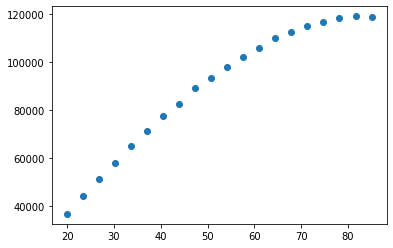

In [174]:
plt.plot(mp.elevation, mp.pressure, "o")

In [175]:
elevation = load_elevation[i]
await attcs.point_azel(az=0., el=load_elevation[i], wait_dome=False)
max_pressure = coeff*np.cos(np.radians(90-elevation))
await mp.measure_optimum_pressure(max_pressure)
await asyncio.sleep(30.)

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -000.001 | delta Az= +000.001
Axes in position.
None
Optimum load @ el 85.00000065405038: 123.27943150291442
Elevation: 85.00000065405038
Maximum load: 986.2354520233154
Optimum load: 123.27943150291442
Maximum pressure: 125733.36734605322 Pa
Load at maximum pressure: 70.81341439819334
****
Init pressure: 62866.68367302661 Pa (0.5)
load: 508.8058871704103
Optimum load: 123.27943150291442
3.1272569232960956 | 0.01
****
****
Iter 1
Init pressure: 94300.0255095399 Pa (0.7499999999999999)
load: 320.88528928527836
Optimum load: 123.27943150291442
diff: 1.6029101965618036 | tol: 0.01
****
****
Iter 2
Init press

In [177]:
mp.elevation[-1] = load_elevation[-1]

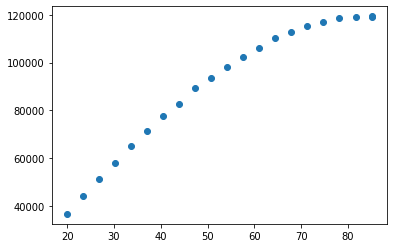

In [178]:
plt.plot(mp.elevation, mp.pressure, "o")

In [179]:
np.save("alt_optimum_pressure.npy", np.array([mp.elevation, mp.pressure]))

RemoteEvent(ATMCS, 0, target) falling behind; read 16 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 20 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 20 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 11 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 10 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 80 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 26 messages


## Fit Elevation vs. Pressure

In [186]:
data = np.array([mp.elevation, mp.pressure])
mask = np.ones(len(mp.pressure), dtype=bool)

In [209]:
fit1 = np.polyfit(np.cos(np.radians(90. - data[0])[mask]), data[1][mask], 1)
fit2 = np.polyfit(np.cos(np.radians(90. - data[0])[mask]), data[1][mask], 2)
fit3 = np.polyfit(np.cos(np.radians(90. - data[0][mask])), data[1][mask], 3)
fit4 = np.polyfit(np.cos(np.radians(90. - data[0][mask])), data[1][mask], 4)
fit5 = np.polyfit(np.cos(np.radians(90. - data[0][mask])), data[1][mask], 5)
fit7 = np.polyfit(np.cos(np.radians(90. - data[0][mask])), data[1][mask], 7)

poly1 = np.poly1d(fit1)
poly2 = np.poly1d(fit2)
poly3 = np.poly1d(fit3)
poly4 = np.poly1d(fit4)
poly5 = np.poly1d(fit5)
poly7 = np.poly1d(fit7)

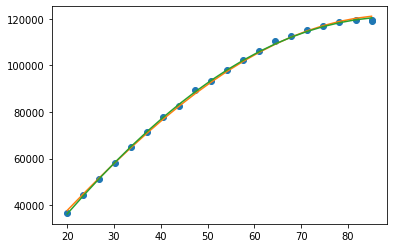

In [205]:
plt.plot(data[0][mask], data[1][mask], "o")
plt.plot(data[0][mask], poly1(np.cos(np.radians(90. - data[0][mask]))))
plt.plot(data[0][mask], poly2(np.cos(np.radians(90. - data[0][mask]))))

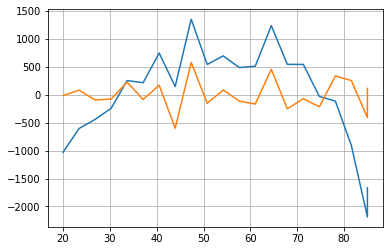

In [212]:
plt.plot(data[0][mask], data[1][mask]-poly1(np.cos(np.radians(90. - data[0][mask]))), "-")
# plt.plot(data[0][mask], data[1][mask]-poly2(np.cos(np.radians(90. - data[0][mask]))), "-")
# plt.plot(data[0][mask], data[1][mask]-poly3(np.cos(np.radians(90. - data[0][mask]))), "-")
# plt.plot(data[0][mask], data[1][mask]-poly4(np.cos(np.radians(90. - data[0][mask]))), "-")
# plt.plot(data[0][mask], data[1][mask]-poly5(np.cos(np.radians(90. - data[0][mask]))), "-")
plt.plot(data[0][mask], data[1][mask]-poly7(np.cos(np.radians(90. - data[0][mask]))), "-")
plt.grid()

In [214]:
fit1

array([127308.19091435,  -5780.04869127])

In [232]:
b'test'.decode()

'test'

In [239]:
for coeff in fit7:
    print(f"- {coeff:+14.3f}")

-  -23093764.324
- +102195277.538
- -189824540.387
- +191664153.580
- -113529679.686
-  +39429444.367
-   -7299398.286
-    +577871.121


In [180]:
ss = await attcs.atmcs.evt_summaryState.aget(timeout=5)

In [181]:
print(salobj.State(ss.summaryState))

State.ENABLED
RemoteEvent(ATMCS, 0, target) falling behind; read 44 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 20 messages


In [102]:
await mp.measure_optimum_load()

Optimum load @ el 79.9999996109691: 119.67555270080568


(79.9999996109691, 119.67555270080568)

In [104]:
await mp.measure_optimum_load()

Optimum load @ el 19.999996928789187: 29.3236292427063


(19.999996928789187, 29.3236292427063)

In [105]:
await mp.get_load()

236.6911056793213

In [74]:
current_pressure = await mp.get_pressure()

In [27]:
await mp.get_elevation()

15.036000518433866

In [58]:
mp.min_allowed_load

120.0

In [77]:
# current_pressure.to(u.Pa).value
await attcs.atpneumatics.cmd_m1SetPressure.set_start(pressure=9000)

In [71]:
current_load = await mp.get_load()
current_pressure = await mp.get_pressure()

next_pressure = current_pressure * 1.000
print(f"{current_pressure} -> {next_pressure}")

attcs.atpneumatics.evt_m1SetPressure.flush()
await attcs.atpneumatics.cmd_m1SetPressure.set_start(pressure=next_pressure.to(u.Pa).value)

try:
    await attcs.atpneumatics.evt_m1SetPressure.next(flush=True, timeout=5)
except asyncio.TimeoutError:
    pass

new_load = await mp.get_load()
new_pressure = await mp.get_pressure()

print(f"Min allowed load: {mp.min_allowed_load}")
print(f"Load: {current_load} -> {new_load}")
print(f"Pressure: {current_pressure} -> {new_pressure}")

11068.900895996096 Pa -> 11068.900895996096 Pa
Min allowed load: 120.0
Load: 180.50599289245605 -> 117.35492523193359
Pressure: 11068.900895996096 Pa -> 19968.039672851566 Pa


In [38]:
await attcs.atpneumatics.cmd_openMasterAirSupply.start()

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=1673575377, ack=<SalRetCode.CMD_NOPERM: -300>, error=0, result='ERROR: Command masterOpenValve rejected while in EnabledState state.')

In [51]:
await attcs.atpneumatics.cmd_openInstrumentAirValve.start()

In [73]:
await attcs.atpneumatics.cmd_m1SetPressure.set_start(pressure=0.)

In [47]:
await attcs.atpneumatics.cmd_openInstrumentAirValve.start()

In [124]:
await attcs.atpneumatics.cmd_m1OpenAirValve.start()

In [45]:
await salobj.set_summary_state(attcs.atpneumatics, salobj.State.ENABLED)

[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [121]:
await attcs.point_azel(az=0., el=20., wait_dome=False)

Sending command
Stop tracking.
Mount tracking state is 9
Tracking state: 10.
Tracking state: 8.
In Position: True.
In Position: False.
Scheduling check coroutines
process as completed...
Got False
Telescope not in position
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -065.003 | delta Az= +000.001
[Telescope] delta Alt = -064.268 | delta Az= +000.001
[Telescope] delta Alt = -063.269 | delta Az= +000.001
[Telescope] delta Alt = -062.752 | delta Az= +000.000
[Telescope] delta Alt = -059.778 | delta Az= +000.000
[Telescope] delta Alt = -055.780 | delta Az= +000.000
[Telescope] delta Alt = -051.778 | delta Az= +000.000
[Telescope] delta Alt = -047.776 | delta Az= +000.000
[Telescope] delta Alt = -045.777 | delta Az= +000.000
[Telescope] delta Alt = -041.779 | delta Az= +000.000
[Telescope] delta Alt = -039.777 | delta Az= -000.000
[Telescope] delta Alt = -035.775 | delta A

In [84]:
await attcs.cancel_not_done(attcs.scheduled_coro)

In [167]:
attcs.scheduled_coro

[]

In [97]:
# current_pressure.to(u.Pa).value
await attcs.atpneumatics.cmd_m1SetPressure.set_start(pressure=0.)

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=1069051793, ack=<SalRetCode.CMD_NOPERM: -300>, error=0, result='ERROR: Command m1SetPressure rejected while in EnabledState state.')

In [236]:
await attcs.ataos.cmd_enableCorrection.set_start(m1=True)

In [237]:
await attcs.ataos.cmd_disableCorrection.set_start(m1=True)

In [165]:
await attcs.atpneumatics.cmd_m1OpenAirValve.start()

In [238]:
await salobj.set_summary_state(attcs.ataos, salobj.State.STANDBY)

[<State.FAULT: 3>, <State.STANDBY: 5>]

In [240]:
await attcs.enable()

Gathering settings.
No settings for atmcs.
Using                                                                                                                                 from settingVersions event.
No settings for atptg.
Couldn't get settingVersions event. Using empty settings.
No settings for ataos.
Using current from settingVersions event.
No settings for atpneumatics.
Using                                                                                                                                 from settingVersions event.
No settings for athexapod.
Using current from settingVersions event.
No settings for atdome.
Using test from settingVersions event.
No settings for atdometrajectory.
Using  from settingVersions event.
Settings versions: {'atmcs': '                                                                                                                               ', 'atptg': '', 'ataos': 'current', 'atpneumatics': '                                              

In [241]:
await attcs.ataos.cmd_enableCorrection.set_start(m1=True)

In [242]:
await attcs.ataos.cmd_enableCorrection.set_start(hexapod=True, m1=False)

RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 19 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 21 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 20 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 13 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 10 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 80 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 30 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 16 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 60 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 19 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 80 messages
RemoteEv